In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import RidgeCV

In [103]:
cfg = {
    'house_pricing': {
        'train_dataset': '/home/alexandra/projects/ml_hw/train_hw.csv'
    }
}
train_data = pd.read_csv(cfg['house_pricing']['train_dataset'])
cfg = {
    'house_pricing': {
        'test_dataset': '/home/alexandra/projects/ml_hw/test_hw.csv'
    }
}
test_data = pd.read_csv(cfg['house_pricing']['test_dataset'])

ПРОВЕРКА ДАННЫХ

In [104]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,20,RL,NaN,8750,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,8,2009,WD,Normal,148500
1,2,160,RM,24.0,2368,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2009,WD,Normal,125000
2,3,60,RL,80.0,9760,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,167900
3,4,120,RM,NaN,4500,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,165000
4,5,80,RL,NaN,14112,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,180500


In [105]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   MSZoning       1168 non-null   object 
 3   LotFrontage    959 non-null    float64
 4   LotArea        1168 non-null   int64  
 5   Street         1168 non-null   object 
 6   Alley          71 non-null     object 
 7   LotShape       1168 non-null   object 
 8   LandContour    1168 non-null   object 
 9   Utilities      1168 non-null   object 
 10  LotConfig      1168 non-null   object 
 11  LandSlope      1168 non-null   object 
 12  Neighborhood   1168 non-null   object 
 13  Condition1     1168 non-null   object 
 14  Condition2     1168 non-null   object 
 15  BldgType       1168 non-null   object 
 16  HouseStyle     1168 non-null   object 
 17  OverallQual    1168 non-null   int64  
 18  OverallC

Вряд ли чем то поможет колонка id, выбросы по цене и колонки с большим количеством нулей тоже лучше убрать

In [106]:
train_data = train_data.drop(columns = ['Id'])

In [107]:
train_data = train_data[train_data['SalePrice'] < 500000]

In [108]:
train_data = train_data.dropna(thresh=len(train_data)*0.8, axis=1)

Тут можно посмотреть как вообще расположены различные характеристики 

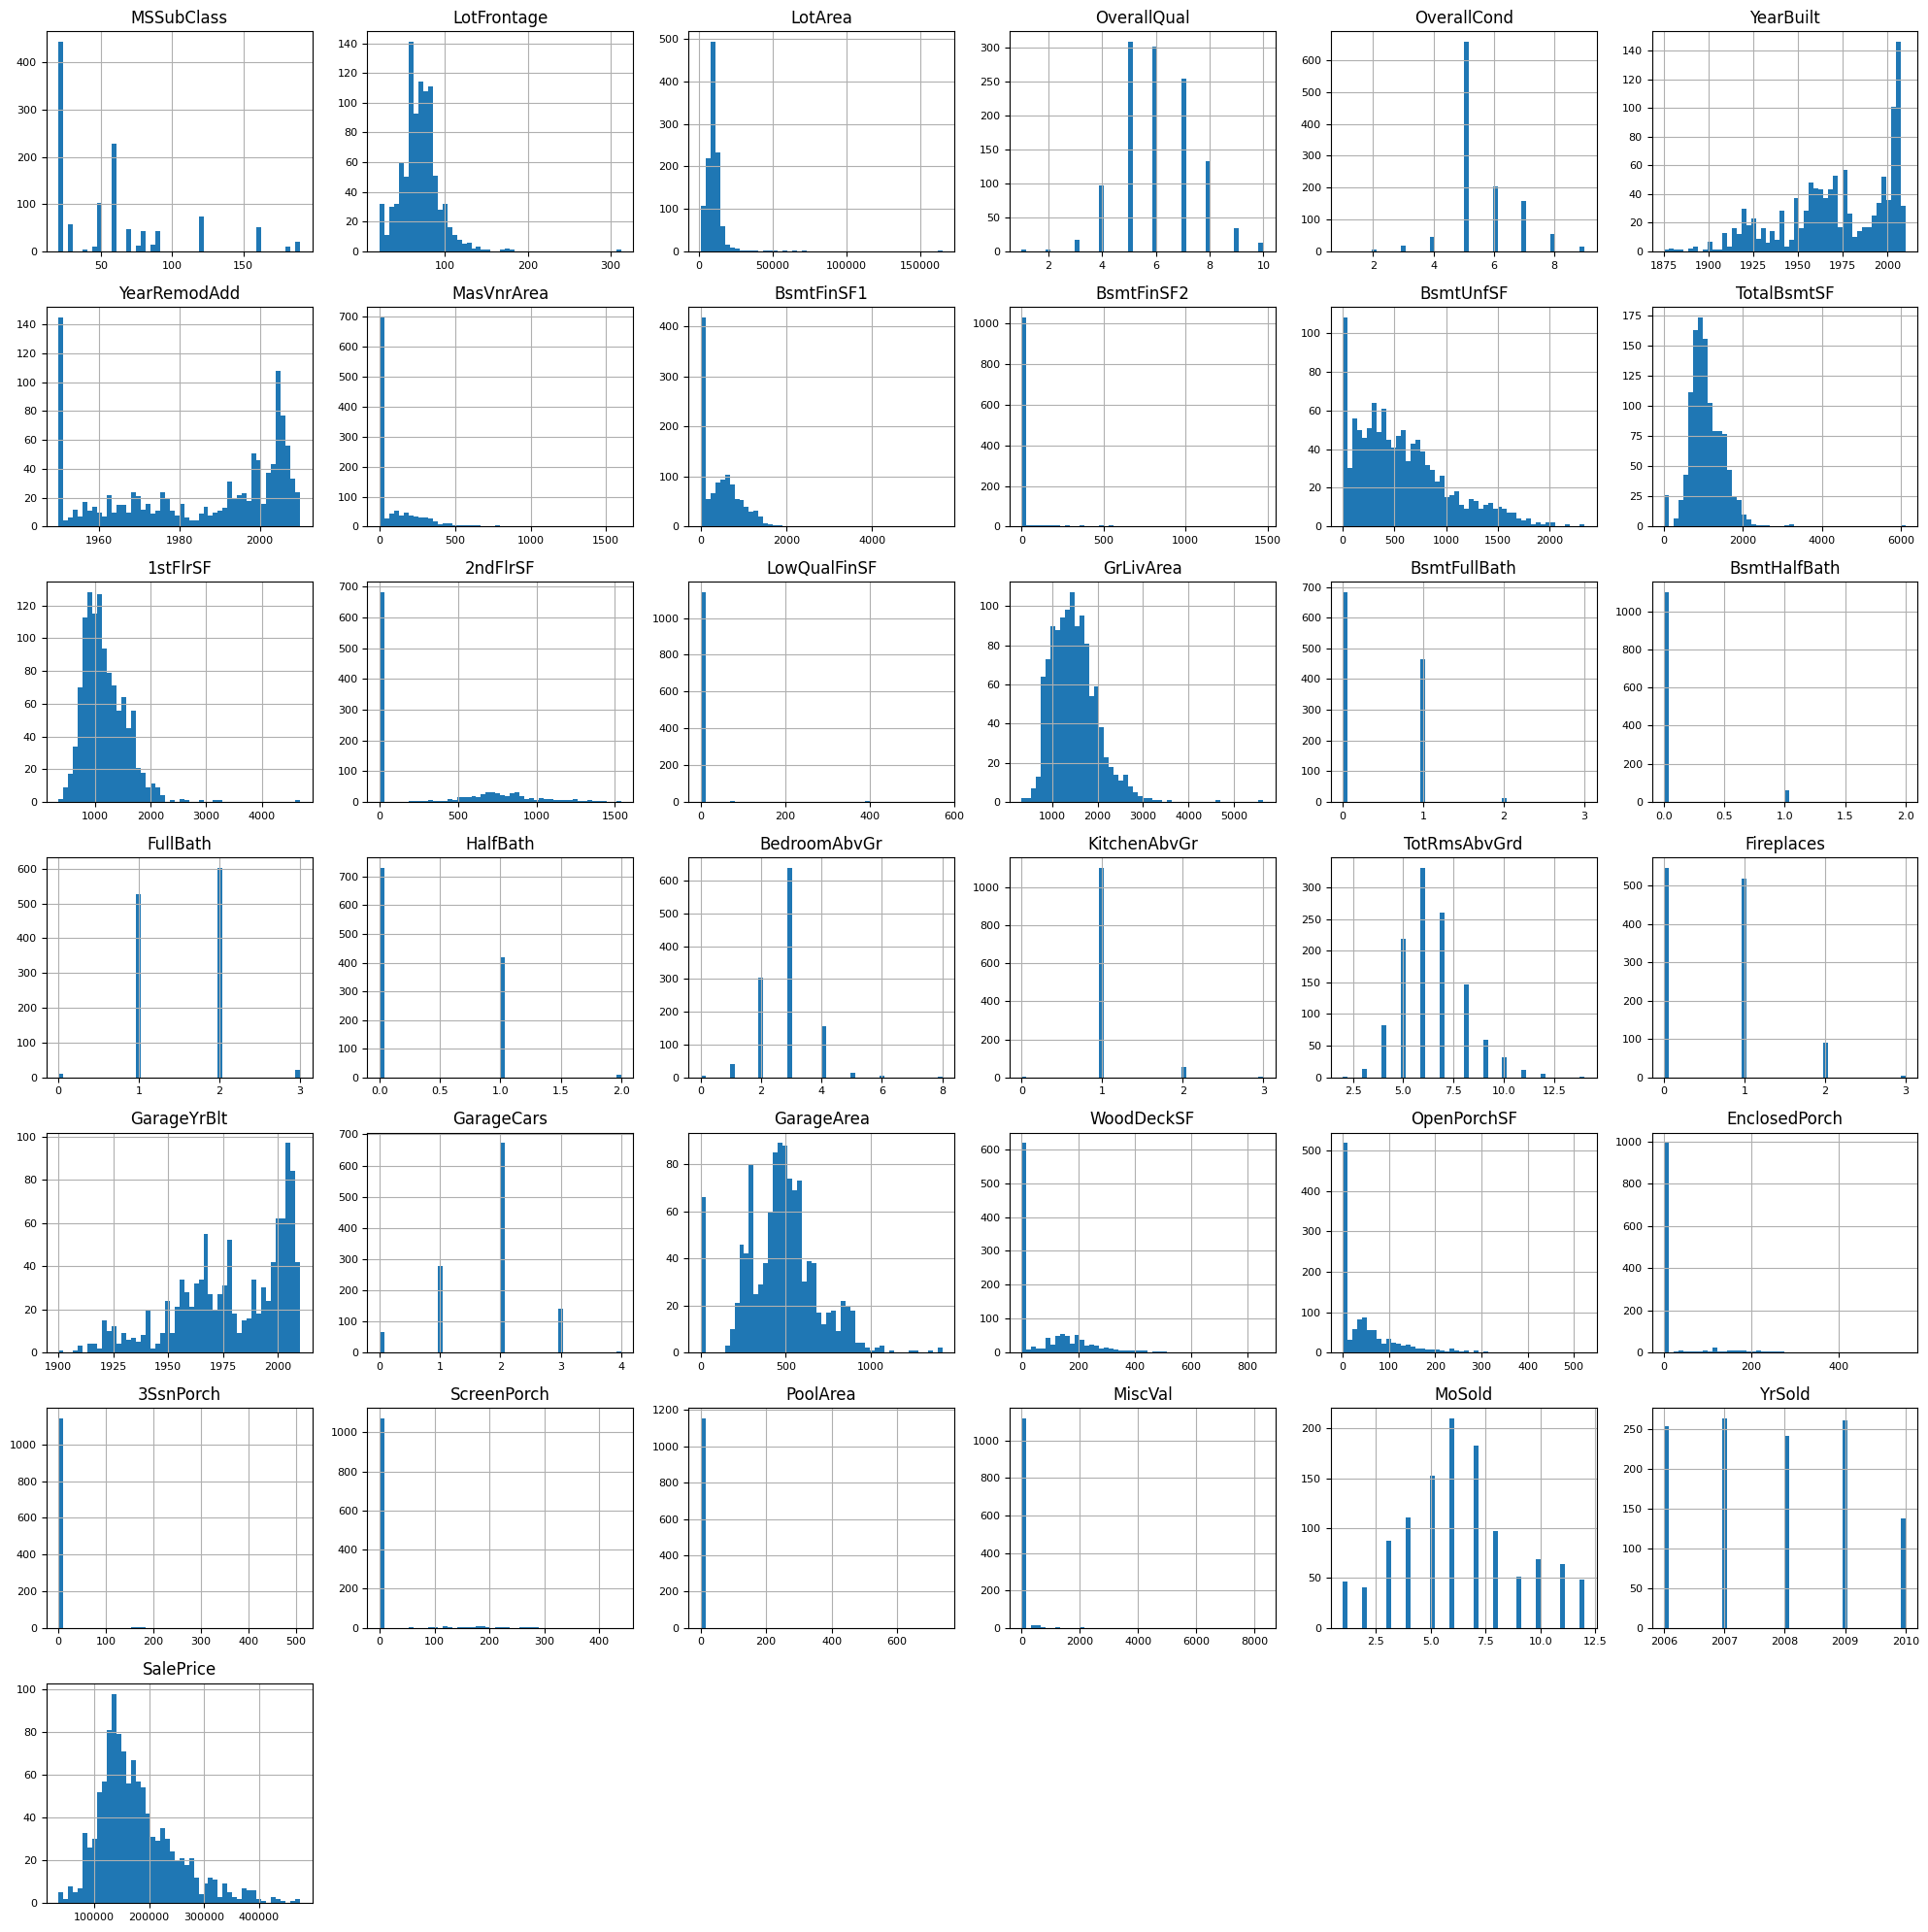

In [109]:
df_num = train_data.select_dtypes(include=['float64', 'int64'])
df_num.hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

По последней гистограмме видно что большая часть домов была продана по цене меньшей чем средняя, и распределение у нее не очень хорошее, лучше прологарифмировать

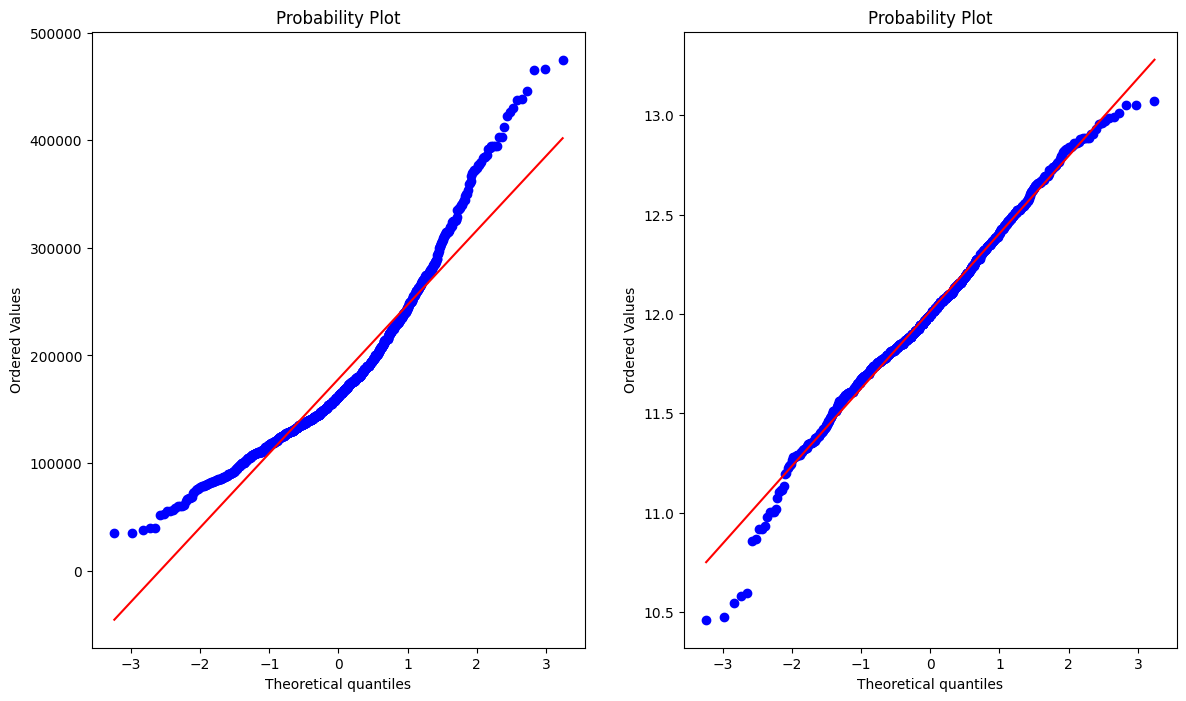

In [110]:
from scipy import stats 
fig = plt.figure(figsize = (14,8))
fig.add_subplot(1,2,1)
res = stats.probplot(train_data['SalePrice'], plot=plt)
fig.add_subplot(1,2,2)
res = stats.probplot(np.log1p(train_data['SalePrice']), plot=plt)

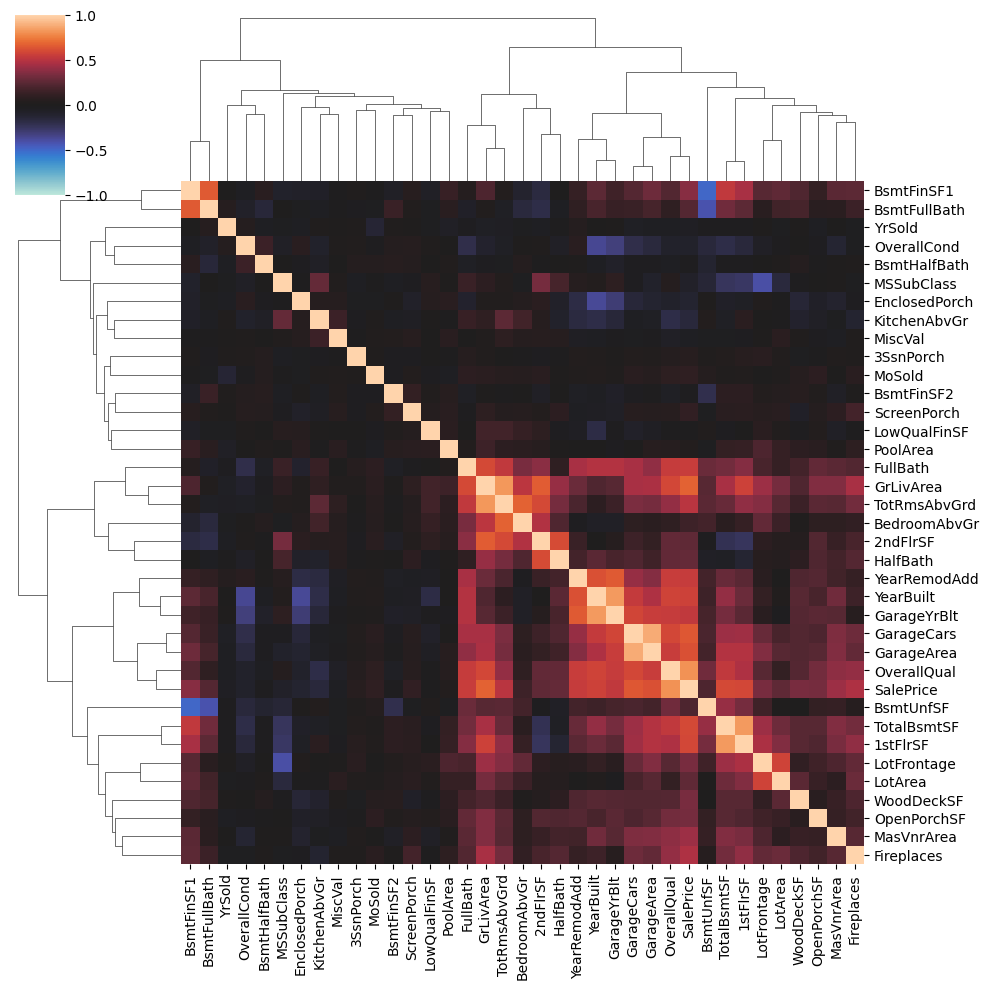

In [111]:
def corrplot(test_data, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        test_data.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(df_num, annot=None)

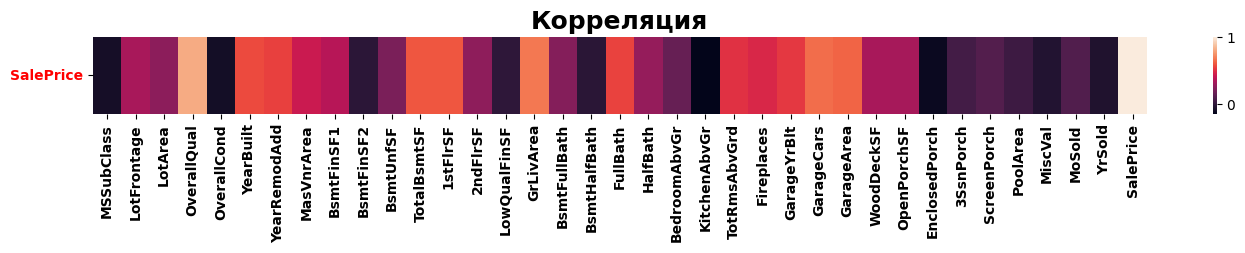

In [112]:

numetrical = train_data.select_dtypes(exclude = 'object')
corr_numetrical = numetrical.corr()
f, ax = plt.subplots(figsize = (17, 1))
sns.heatmap(corr_numetrical.sort_values(by = ['SalePrice'], ascending = False).head(1))
plt.title('Корреляция', weight = 'bold', fontsize = 18)
plt.xticks(weight='bold')
plt.yticks(weight='bold', color='red', rotation=0)
plt.show()



Больше всего перспектив у GrLivArea и OverallQual

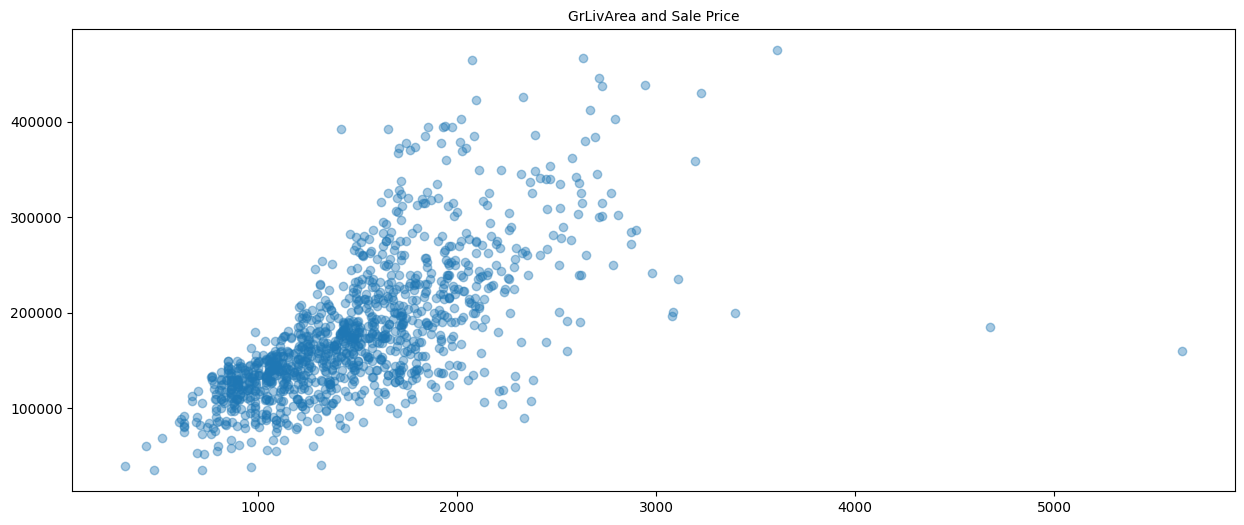

In [113]:
plt.figure(figsize = ((15, 6)))
plt.scatter(x = 'GrLivArea', y = 'SalePrice', data = train_data, alpha=0.4)
plt.title('GrLivArea and Sale Price', fontsize = 10)
plt.show()

Зависимость практически линейная

Удалим выбросы

In [114]:
train_data = train_data[train_data['GrLivArea'] < 4500]

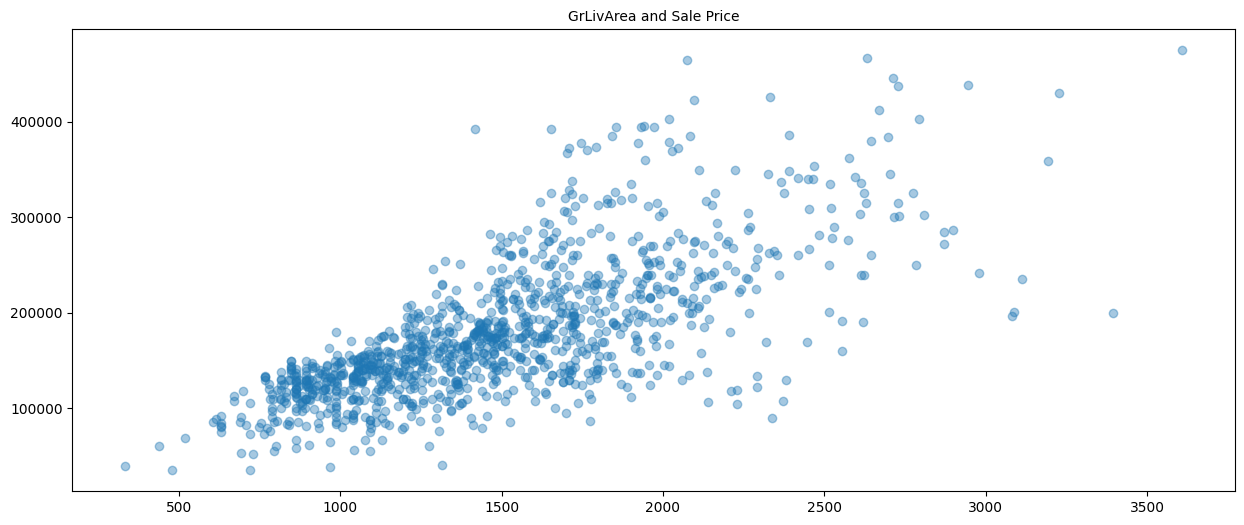

In [115]:
plt.figure(figsize = ((15, 6)))
plt.scatter(x = 'GrLivArea', y = 'SalePrice', data = train_data, alpha=0.4)
plt.title('GrLivArea and Sale Price', fontsize = 10)
plt.show()

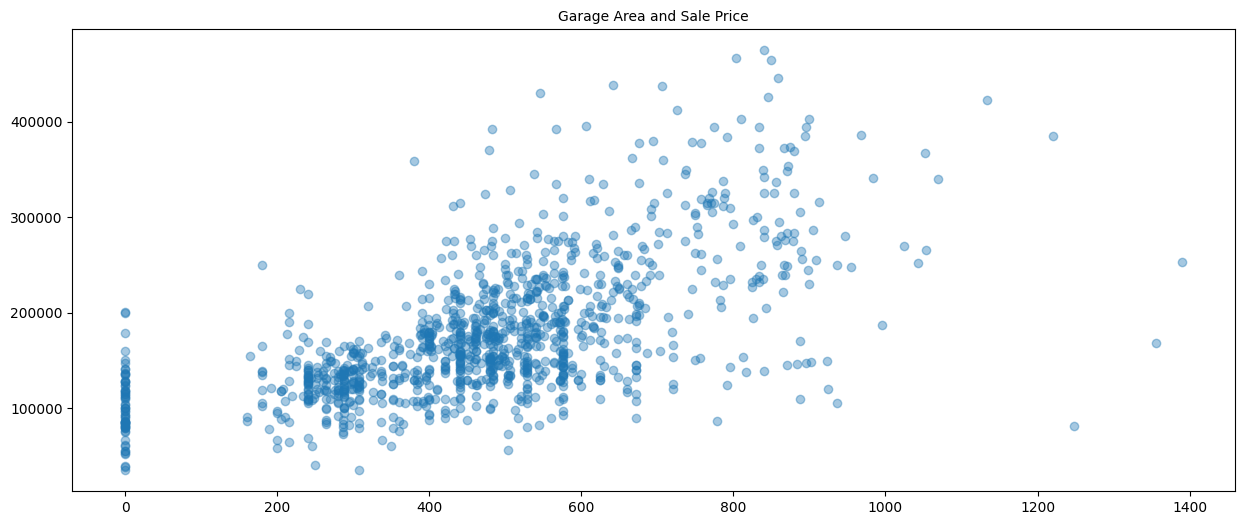

In [116]:
plt.figure(figsize = ((15, 6)))
plt.scatter(x = 'GarageArea', y = 'SalePrice', data = train_data, alpha=0.4)
plt.title('Garage Area and Sale Price', fontsize = 10)

plt.show()

<Figure size 1500x1000 with 0 Axes>

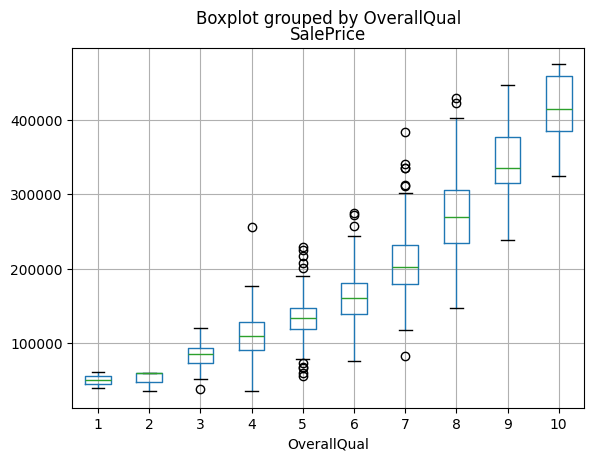

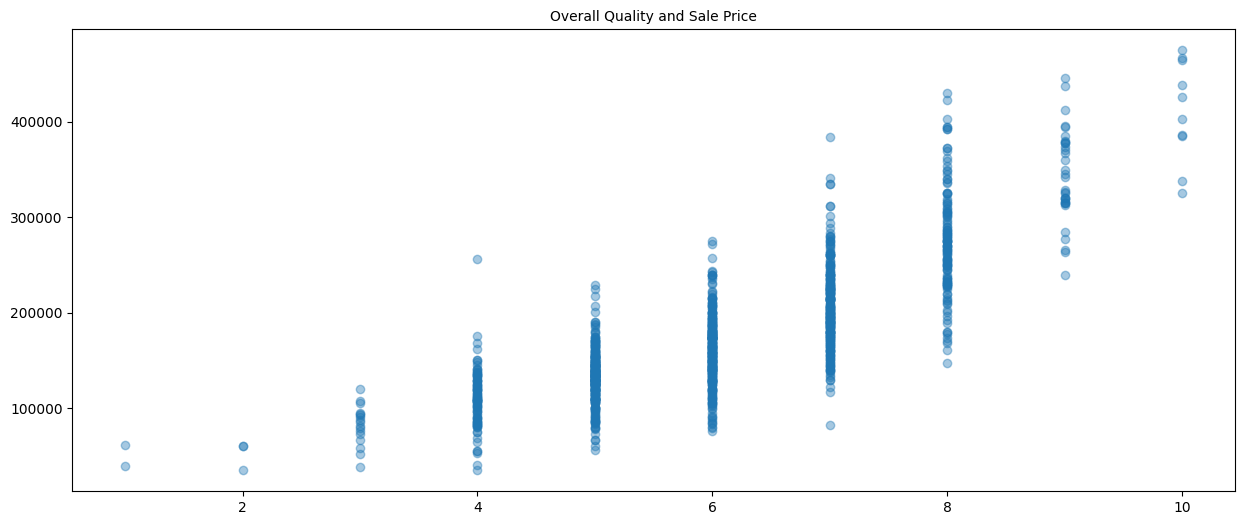

In [117]:
plt.figure(figsize = ((15, 10)))
train_data.boxplot(by = 'OverallQual', column = 'SalePrice')
plt.show()
plt.figure(figsize = ((15, 6)))
plt.scatter(x = 'OverallQual', y = 'SalePrice', data = train_data,alpha=0.4)
plt.title('Overall Quality and Sale Price', fontsize = 10)
plt.show()


МАНИПУЛЯЦИИ

Прологарифмируем целевую переменную как было уже сказано выше и удалим выбросы в полезных категориях

In [118]:
train_data['SalePrice'] = np.log1p(train_data['SalePrice'])

In [119]:
train_data = train_data.drop(train_data[(train_data['OverallQual'] > 9) & (train_data['SalePrice'] < 220000)].index)

Уберем малоинформативные колонки с одинаковыми значениями

In [120]:
def get_almost_constant_columns(df, dropna=True):
    cols = []
    for i in df:
        if dropna:
            counts = df[i].dropna().value_counts()
        else:
            counts = df[i].value_counts()
        most_popular_value_count = counts.iloc[0]
        if (most_popular_value_count / len(df)) * 100 > 95:
            cols.append(i)
    return cols



In [121]:
cat_df = train_data.select_dtypes(include=['object'])
overfit_cat = get_almost_constant_columns(cat_df)
train_data = train_data.drop(overfit_cat, axis=1)
overfit_cat



['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']

In [122]:
num_df = train_data.select_dtypes(exclude=['object'])
overfit_num = get_almost_constant_columns(num_df, dropna=True)
train_data = train_data.drop(overfit_num, axis=1)
overfit_num

['LowQualFinSF', 'KitchenAbvGr', '3SsnPorch', 'PoolArea', 'MiscVal']

Уберем мультиколлинеарность

In [123]:
num_df = train_data.select_dtypes(include=np.number).columns.tolist()
num_df.remove('SalePrice') 
corr_matrix = train_data[num_df].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
num_df = [col for col in num_df if col not in to_drop]
train_data = train_data.drop(to_drop, axis=1)
test_data = test_data.drop(to_drop, axis=1)
cat_df = train_data.select_dtypes(include=['object']).columns.tolist()

Заполним пропуски (onehot encoder дает результат хуже
MSE: 616885216.76
RMSE: 24837.17
MAE: 15082.23
R²: 0.87)

In [124]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_df),
        
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder()) 
        ]), cat_df)
    ])

Обучение и сравнение моделей

In [125]:
X = train_data.drop('SalePrice', axis=1)
y = train_data['SalePrice']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RidgeCV(alphas=(0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10), cv=5))
])
linear_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
ridge_pipeline.fit(X_train, y_train)
linear_pipeline.fit(X_train, y_train)
ridge_pred = ridge_pipeline.predict(X_val)
linear_pred = linear_pipeline.predict(X_val)

def evaluate_model(name, y_true, y_pred):
    y_pred_exp = np.expm1(y_pred)
    y_true_exp = np.expm1(y_true)
    
    print(f"MSE: {mean_squared_error(y_true_exp, y_pred_exp):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true_exp, y_pred_exp)):.2f}")
    print(f"MAE: {mean_absolute_error(y_true_exp, y_pred_exp):.2f}")
    print(f"R²: {r2_score(y_true_exp, y_pred_exp):.2f}")
    return {
        'MSE': mean_squared_error(y_true_exp, y_pred_exp),
        'RMSE': np.sqrt(mean_squared_error(y_true_exp, y_pred_exp)),
        'MAE': mean_absolute_error(y_true_exp, y_pred_exp),
        'R²': r2_score(y_true_exp, y_pred_exp)
    }

ridge_metrics = evaluate_model("RidgeCV", y_val, ridge_pred)
linear_metrics = evaluate_model("Linear Regression", y_val, linear_pred)

best_model = 'RidgeCV' if ridge_metrics['RMSE'] < linear_metrics['RMSE'] else 'Linear Regression'
print(f"\nЛучшая модель: {best_model}")



MSE: 479595436.64
RMSE: 21899.67
MAE: 14891.72
R²: 0.90
MSE: 499437415.93
RMSE: 22348.10
MAE: 14846.14
R²: 0.90

Лучшая модель: RidgeCV


In [126]:
test_preprocessed = ridge_pipeline.named_steps['preprocessor'].transform(test_data.drop('Id', axis=1))
test_predictions = ridge_pipeline.named_steps['regressor'].predict(test_preprocessed)
test_predictions_exp = np.expm1(test_predictions)

submission = pd.DataFrame({
    'Id': test_data['Id'],
    'SalePrice': test_predictions_exp
})

submission.to_csv('submission.csv', index=False)